In [5]:
import numpy as np
import pandas as pd
import os
import time
import pydicom as dicom
import pydicom
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import json
import glob
import collections
#from pydicom.pixel_data_handlers.util import apply_voi_lut
#import cv2
#from skimage import measure
#from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import random
from glob import glob
import warnings
warnings.filterwarnings('ignore')

### Load Data

In [6]:
train_series = pd.read_csv('data/train_series_descriptions.csv')
df_train = pd.read_csv('data/train.csv')
test_series = pd.read_csv('data/test_series_descriptions.csv')

prepared = False

### Display Sample Images

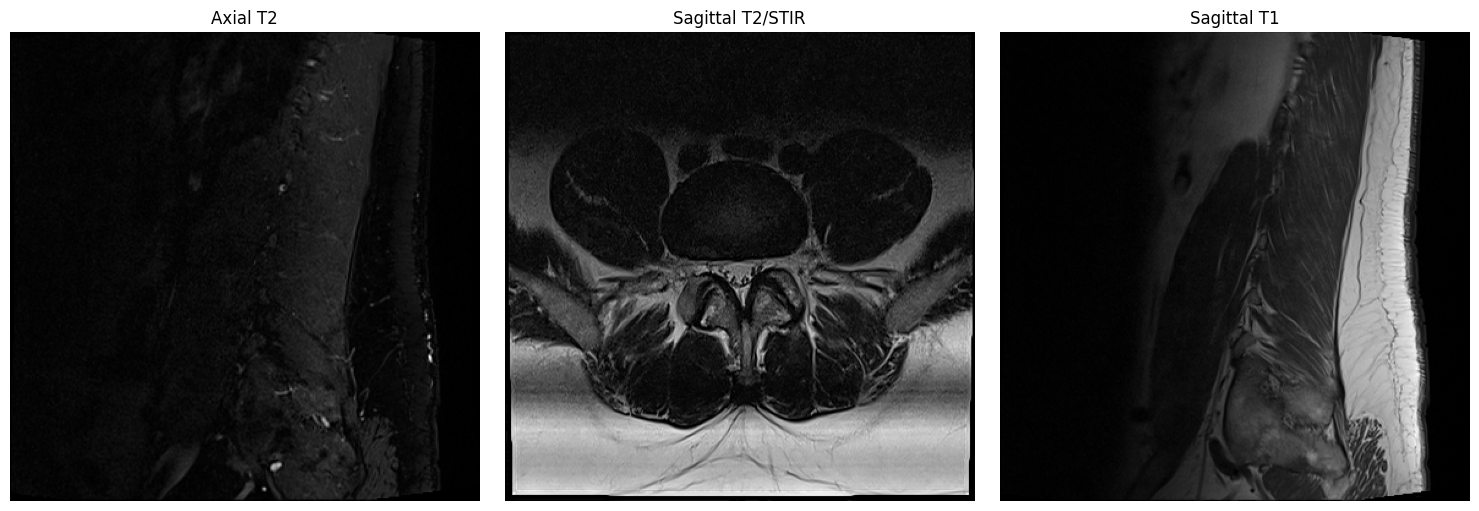

In [7]:
folder_path = 'images/train_images/7143189'

study_id = folder_path.split('/')[-2]
series_ids = [f for f in os.listdir(folder_path)]
dicom_files = {}
for series in series_ids:
    image = os.listdir(f"{folder_path}/{series}")[8]
    dicom_files[series] = image

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
types = ["Axial T2", "Sagittal T2/STIR", "Sagittal T1"]

for i, (series, dicom_file) in enumerate(dicom_files.items()):
    dicom_file_path = os.path.join(folder_path, series, dicom_file)
    dicom_data = pydicom.dcmread(dicom_file_path)
    image = dicom_data.pixel_array   
    axs[i].imshow(image, cmap='gray')
    axs[i].set_title(types[i])
    axs[i].axis('off')   

plt.tight_layout()
plt.show()

### Subset Data

In [8]:
df_train

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970,4282019580,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate
1971,4283570761,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1972,4284048608,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild
1973,4287160193,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Severe,Moderate,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild


In [9]:
train_series

,study_id,series_id,series_description
0,4003253,702807833,Sagittal T2/STIR
1,4003253,1054713880,Sagittal T1
2,4003253,2448190387,Axial T2
3,4646740,3201256954,Axial T2
4,4646740,3486248476,Sagittal T1
...,...,...,...
6289,4287160193,1507070277,Sagittal T2/STIR
6290,4287160193,1820446240,Axial T2
6291,4290709089,3274612423,Sagittal T2/STIR
6292,4290709089,3390218084,Axial T2


In [10]:
test_series

,study_id,series_id,series_description
0,44036939,2828203845,Sagittal T1
1,44036939,3481971518,Axial T2
2,44036939,3844393089,Sagittal T2/STIR


Training data: 1975 studies, predict 25 target columns<br>
Testing data: 3 studies, predict 25 target columns<br>
Each study has 3 series (Sagittal T2, Sagittal T1, Axial T2)

### Subset Data & Images

In [11]:
grouped = {}
unique_scans = train_series["series_description"].unique()

for scan in unique_scans:
    grouped[scan] = train_series[train_series['series_description'] == scan]

sagittal_t1_df = grouped["Sagittal T1"]
sagittal_t2_df = grouped["Sagittal T2/STIR"]
axial_t2_df = grouped["Axial T2"]

In [12]:
def load_images(df):
    images = {}
    for _, row in df.iterrows():
        folder_path = f"images/train_images/{row['study_id']}/{row['series_id']}"
        dicom_files = [f for f in os.listdir(folder_path) if f.endswith('.dcm')]
        for dicom_file in dicom_files:
            dicom_file_path = os.path.join(folder_path, dicom_file)
            dicom_data = pydicom.dcmread(dicom_file_path)
            image = dicom_data.pixel_array      # image size: 384x384
            image = image / 255.0               # normalize pixel values
            images[row['study_id']] = image
    return images

In [ ]:
sagittal_t1_images_to_save = load_images(sagittal_t1_df)
sagittal_t2_images_to_save = load_images(sagittal_t2_df)
axial_t2_images_to_save = load_images(axial_t2_df)

KeyboardInterrupt: 

In [13]:
def save_images(images, filename):
    with open(filename, 'wb') as f:
        pickle.dump(images, f)
    print(f"Images saved to {filename}")

def load_saved_images(filename):
    with open(filename, 'rb') as f:
        images = pickle.load(f)
    print(f"Images loaded from {filename}")
    return images


In [ ]:
# Save the images to disk
save_images(sagittal_t1_images_to_save, 'data/sagittal_t1_images.pkl')
save_images(sagittal_t2_images_to_save, 'data/sagittal_t2_images.pkl')
save_images(axial_t2_images_to_save, 'data/axial_t2_images.pkl')

Images saved to data/sagittal_t1_images.pkl
Images saved to data/sagittal_t2_images.pkl
Images saved to data/axial_t2_images.pkl


In [14]:
# Load the images from the serialized files
sagittal_t1_images = load_saved_images('data/sagittal_t1_images.pkl')
sagittal_t2_images = load_saved_images('data/sagittal_t2_images.pkl')
axial_t2_images = load_saved_images('data/axial_t2_images.pkl')

Images loaded from data/sagittal_t1_images.pkl
Images loaded from data/sagittal_t2_images.pkl
Images loaded from data/axial_t2_images.pkl


In [15]:
sagittal_t1_images

{4003253: array([[0.00784314, 0.00392157, 0.00392157, ..., 0.        , 0.        ,
         0.        ],
        [0.00784314, 0.01568627, 0.01960784, ..., 0.        , 0.        ,
         0.        ],
        [0.00392157, 0.01568627, 0.01960784, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.00784314, 0.00784314, 0.00784314, ..., 0.        , 0.        ,
         0.        ],
        [0.00392157, 0.00784314, 0.01176471, ..., 0.        , 0.        ,
         0.        ],
        [0.00392157, 0.00392157, 0.00392157, ..., 0.        , 0.        ,
         0.        ]]),
 4646740: array([[0.01960784, 0.01176471, 0.00392157, ..., 0.        , 0.        ,
         0.        ],
        [0.02745098, 0.0627451 , 0.07843137, ..., 0.        , 0.        ,
         0.        ],
        [0.03529412, 0.0745098 , 0.08627451, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.00784314, 0.01568627, 0.01960784, ..., 0.00392157, 0.        ,
         0.     

In [16]:
axial_t2_images

{4003253: array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.01176471, 0.02745098, ..., 0.05098039, 0.01176471,
         0.01176471],
        [0.        , 0.00784314, 0.03529412, ..., 0.04705882, 0.00784314,
         0.01176471],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 4646740: array([[0.        , 0.03529412, 0.04313725, ..., 0.03137255, 0.03921569,
         0.03137255],
        [0.        , 0.02745098, 0.2745098 , ..., 0.17647059, 0.1254902 ,
         0.16078431],
        [0.        , 0.04705882, 0.28235294, ..., 0.23921569, 0.18431373,
         0.2       ],
        ...,
        [0.        , 0.        , 0.02745098, ..., 1.18431373, 1.04705882,
         0.     

### Prepare X and Y

In [17]:

# Label Encoding for target vars
labels = {"Normal/Mild": 0, "Moderate": 1, "Severe": 2} 

if not prepared:
    for col in df_train.columns[1:]:
        df_train[col] = df_train[col].map(labels)

prepared = True

df_train

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4646740,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0
2,7143189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8785691,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10728036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970,4282019580,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
1971,4283570761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1972,4284048608,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0
1973,4287160193,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


In [34]:
# Check for NaNs in the label columns after mapping
label_columns = df_train.columns[1:]
missing_labels = df_train[label_columns].isnull().sum()

print("Missing label counts after mapping:")
print(missing_labels)


Missing label counts after mapping:
spinal_canal_stenosis_l1_l2                 1
spinal_canal_stenosis_l2_l3                 1
spinal_canal_stenosis_l3_l4                 1
spinal_canal_stenosis_l4_l5                 1
spinal_canal_stenosis_l5_s1                 1
left_neural_foraminal_narrowing_l1_l2       2
left_neural_foraminal_narrowing_l2_l3       2
left_neural_foraminal_narrowing_l3_l4       2
left_neural_foraminal_narrowing_l4_l5       2
left_neural_foraminal_narrowing_l5_s1       2
right_neural_foraminal_narrowing_l1_l2      8
right_neural_foraminal_narrowing_l2_l3      8
right_neural_foraminal_narrowing_l3_l4      8
right_neural_foraminal_narrowing_l4_l5      8
right_neural_foraminal_narrowing_l5_s1      8
left_subarticular_stenosis_l1_l2          164
left_subarticular_stenosis_l2_l3           82
left_subarticular_stenosis_l3_l4            3
left_subarticular_stenosis_l4_l5            3
left_subarticular_stenosis_l5_s1           11
right_subarticular_stenosis_l1_l2         16

In [35]:
for col in label_columns:
    unmapped = df_train[df_train[col].isnull()][col].unique()
    if len(unmapped) > 0:
        print(f"Unmapped labels in column '{col}': {unmapped}")


Unmapped labels in column 'spinal_canal_stenosis_l1_l2': [nan]
Unmapped labels in column 'spinal_canal_stenosis_l2_l3': [nan]
Unmapped labels in column 'spinal_canal_stenosis_l3_l4': [nan]
Unmapped labels in column 'spinal_canal_stenosis_l4_l5': [nan]
Unmapped labels in column 'spinal_canal_stenosis_l5_s1': [nan]
Unmapped labels in column 'left_neural_foraminal_narrowing_l1_l2': [nan]
Unmapped labels in column 'left_neural_foraminal_narrowing_l2_l3': [nan]
Unmapped labels in column 'left_neural_foraminal_narrowing_l3_l4': [nan]
Unmapped labels in column 'left_neural_foraminal_narrowing_l4_l5': [nan]
Unmapped labels in column 'left_neural_foraminal_narrowing_l5_s1': [nan]
Unmapped labels in column 'right_neural_foraminal_narrowing_l1_l2': [nan]
Unmapped labels in column 'right_neural_foraminal_narrowing_l2_l3': [nan]
Unmapped labels in column 'right_neural_foraminal_narrowing_l3_l4': [nan]
Unmapped labels in column 'right_neural_foraminal_narrowing_l4_l5': [nan]
Unmapped labels in colum

In [36]:
# Remove rows with any NaN labels
initial_count = df_train.shape[0]
df_train.dropna(subset=label_columns, inplace=True)
final_count = df_train.shape[0]
print(f"Removed {initial_count - final_count} samples due to missing labels.")

Removed 185 samples due to missing labels.


In [37]:
X_axial_t2 = []
X_sagittal_t1 = []
X_sagittal_t2 = []
Y = []

for i, row in df_train.iterrows():
    study_id = row["study_id"]

    if study_id in sagittal_t1_images and study_id in sagittal_t2_images and study_id in axial_t2_images:
        X_axial_t2.append(axial_t2_images[study_id])
        X_sagittal_t1.append(sagittal_t1_images[study_id])
        X_sagittal_t2.append(sagittal_t2_images[study_id])
        Y.append((row.iloc[1:]).values)

Some study_ids doo not have all views:

3008676218 .. missing saggital_t2_image

Therefore, they will be removed.

In [38]:
# Labels should be the same length
assert len(X_axial_t2) == len(X_sagittal_t1) == len(X_sagittal_t2) == len(Y)

#### Ensure Images are the Same Size and Data Type

In [39]:
for idx, img in enumerate(X_sagittal_t1[:10]):  # Inspect the first 10 images
    print(f"Image {idx} shape: {img.shape}")


Image 0 shape: (384, 384)
Image 1 shape: (540, 384)
Image 2 shape: (384, 384)
Image 3 shape: (384, 384)
Image 4 shape: (512, 512)
Image 5 shape: (512, 512)
Image 6 shape: (384, 384)
Image 7 shape: (384, 384)
Image 8 shape: (512, 512)
Image 9 shape: (384, 384)


In [40]:
def resize_image(image, target_size=(384, 384)):
    return cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)

def resize_image_in_list(X_list, target_size=(384, 384)):
    for idx, img in enumerate(X_list):
        if img.shape != target_size:
            print(f"Resizing image {idx} from shape {img.shape} to {target_size}")
            img = resize_image(img)
        if not isinstance(img, np.ndarray):
            print(f"Converting image {idx} to NumPy array")
            img = np.array(img, dtype=np.float32)
        else:
            img = img.astype(np.float32)
        X_list[idx] = img
    return X_list

X_axial_t2 = resize_image_in_list(X_axial_t2)
X_sagittal_t1 = resize_image_in_list(X_sagittal_t1)
X_sagittal_t2 = resize_image_in_list(X_sagittal_t2)


Resizing image 0 from shape (320, 320) to (384, 384)
Resizing image 4 from shape (512, 512) to (384, 384)
Resizing image 5 from shape (320, 320) to (384, 384)
Resizing image 6 from shape (320, 320) to (384, 384)
Resizing image 7 from shape (640, 640) to (384, 384)
Resizing image 8 from shape (320, 320) to (384, 384)
Resizing image 9 from shape (320, 320) to (384, 384)
Resizing image 10 from shape (320, 320) to (384, 384)
Resizing image 13 from shape (320, 320) to (384, 384)
Resizing image 14 from shape (512, 512) to (384, 384)
Resizing image 15 from shape (552, 640) to (384, 384)
Resizing image 16 from shape (640, 640) to (384, 384)
Resizing image 17 from shape (512, 512) to (384, 384)
Resizing image 18 from shape (272, 272) to (384, 384)
Resizing image 19 from shape (288, 288) to (384, 384)
Resizing image 20 from shape (640, 640) to (384, 384)
Resizing image 21 from shape (640, 640) to (384, 384)
Resizing image 22 from shape (320, 320) to (384, 384)
Resizing image 23 from shape (640, 

#### One-Hot Encoding

In [41]:
from tensorflow.keras.utils import to_categorical

X_sagittal_t1 = np.array(X_sagittal_t1).reshape(-1, 384, 384, 1)
X_sagittal_t2 = np.array(X_sagittal_t2).reshape(-1, 384, 384, 1)
X_axial_t2 = np.array(X_axial_t2).reshape(-1, 384, 384, 1)

Y = np.array(Y)

# Assuming Y has shape (num_samples, 25) with integer values {0,1,2}
num_classes = 3
Y_one_hot = [to_categorical(Y[:, i], num_classes=num_classes) for i in range(Y.shape[1])]

# Each element in Y_one_hot is of shape (num_samples, 3)


In [45]:
for i, y_cat in enumerate(Y_one_hot):
    print(f"Output {i}:")
    print(y_cat[:5])  # Display the first 5 samples for each target


Output 0:
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
Output 1:
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
Output 2:
[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
Output 3:
[[1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
Output 4:
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
Output 5:
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
Output 6:
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
Output 7:
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
Output 8:
[[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]
Output 9:
[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]
Output 10:
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
Output 11:
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
Output 12:
[[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
Output 13:
[[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
Ou

#### Print Shapes of X and Y

In [42]:
print(f"Shape of X_sagittal_t1: {X_sagittal_t1.shape}")
print(f"Shape of X_sagittal_t2: {X_sagittal_t2.shape}")
print(f"Shape of X_axial_t2: {X_axial_t2.shape}")
print(f"Shape of Y: {Y.shape}")


Shape of X_sagittal_t1: (1790, 384, 384, 1)
Shape of X_sagittal_t2: (1790, 384, 384, 1)
Shape of X_axial_t2: (1790, 384, 384, 1)
Shape of Y: (1790, 25)


### Multi-view CNN

In [47]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2


def create_cnn_branch(input_shape, _):
    input = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(input)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    return input, x

def create_simple_cnn_branch(input_shape, _):
    input = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = GlobalAveragePooling2D()(x)
    
    return input, x

def create_pretrained_branch(input_shape, branch_name):
    input_grayscale = Input(shape=input_shape, name=f'input_{branch_name}')
    x = Conv2D(3, (1, 1), activation='relu')(input_grayscale)  # Convert grayscale to 3 channels
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(input_shape[0], input_shape[1], 3), name=f'base_{branch_name}')
    base_model.trainable = False  # Freeze the base model
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)
    return input_grayscale, x

In [48]:
# Define input shape (height, width, channels)
input_shape = (384, 384, 1)  # Adjust based on your image size

# Create branches for each view
input_axial, branch_axial = create_pretrained_branch(input_shape, "axial")
input_sagittal_t1, branch_sagittal_t1 = create_pretrained_branch(input_shape, "sagittal_t1")
input_sagittal_t2, branch_sagittal_t2 = create_pretrained_branch(input_shape, "sagittal_t2")

# Merge branches
merged = concatenate([branch_axial, branch_sagittal_t1, branch_sagittal_t2])

# Add fully connected layers
x = Dense(128, activation='relu')(merged)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = []
for i in range(Y.shape[1]):
    outputs.append(Dense(num_classes, activation='softmax', name=f'output_{i}')(x))

# Define the model
model = Model(inputs=[input_axial, input_sagittal_t1, input_sagittal_t2], outputs=outputs)

# Model Summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_axial         │ (None, 384, 384,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_sagittal_t1   │ (None, 384, 384,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_sagittal_t2   │ (None, 384, 384,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 384, 384,  │          6 │ input_axial[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 384, 384,  │          6 │ input_sagittal_t… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 384, 384,  │          6 │ input_sagittal_t… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ base_axial          │ (None, 12, 12,    │  2,257,984 │ conv2d_3[0][0]    │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ base_sagittal_t1    │ (None, 12, 12,    │  2,257,984 │ conv2d_4[0][0]    │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ base_sagittal_t2    │ (None, 12, 12,    │  2,257,984 │ conv2d_5[0][0]    │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ base_axial[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ base_sagittal_t1… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ base_sagittal_t2… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 3840)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │    491,648 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_0 (Dense)    │ (None, 3)         │        195 │ dropout_3[0][0] 

 Total params: 7,278,749 (27.77 MB)

 Trainable params: 504,797 (1.93 MB)

 Non-trainable params: 6,773,952 (25.84 MB)

In [60]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics={f'output_{i}': ['accuracy'] for i in range(25)}
)

In [53]:
print(f"X_axial_t2 shape: {X_axial_t2.shape}")      # Expected: (num_samples, 384, 384, 1)
print(f"X_sagittal_t1 shape: {X_sagittal_t1.shape}")  # Expected: (num_samples, 384, 384, 1)
print(f"X_sagittal_t2 shape: {X_sagittal_t2.shape}")  # Expected: (num_samples, 384, 384, 1)")
print(f"Y_one_hot length: {len(Y_one_hot)}")         # Expected: 25
print(f"Each Y_one_hot[i] shape: {Y_one_hot[0].shape}")  # Expected: (num_samples, 3)


X_axial_t2 shape: (1790, 384, 384, 1)
X_sagittal_t1 shape: (1790, 384, 384, 1)
X_sagittal_t2 shape: (1790, 384, 384, 1)
Y_one_hot length: 25
Each Y_one_hot[i] shape: (1790, 3)


In [54]:
from sklearn.model_selection import train_test_split

# Split the image data
Xa_train, Xa_val, Xs1_train, Xs1_val, Xs2_train, Xs2_val = train_test_split(
    X_axial_t2, X_sagittal_t1, X_sagittal_t2, 
    test_size=0.5, 
    random_state=42
)

print(f"Xa_train shape: {Xa_train.shape}")
print(f"Xa_val shape: {Xa_val.shape}")


Xa_train shape: (895, 384, 384, 1)
Xa_val shape: (895, 384, 384, 1)


In [55]:
# Initialize lists to hold split labels
Y_train_list = []
Y_val_list = []

for i, y in enumerate(Y_one_hot):
    y_train, y_val = train_test_split(
        y, 
        test_size=0.5, 
        random_state=42
    )
    Y_train_list.append(y_train)
    Y_val_list.append(y_val)
    print(f"Target {i+1}: Y_train shape: {y_train.shape}, Y_val shape: {y_val.shape}")


Target 1: Y_train shape: (895, 3), Y_val shape: (895, 3)
Target 2: Y_train shape: (895, 3), Y_val shape: (895, 3)
Target 3: Y_train shape: (895, 3), Y_val shape: (895, 3)
Target 4: Y_train shape: (895, 3), Y_val shape: (895, 3)
Target 5: Y_train shape: (895, 3), Y_val shape: (895, 3)
Target 6: Y_train shape: (895, 3), Y_val shape: (895, 3)
Target 7: Y_train shape: (895, 3), Y_val shape: (895, 3)
Target 8: Y_train shape: (895, 3), Y_val shape: (895, 3)
Target 9: Y_train shape: (895, 3), Y_val shape: (895, 3)
Target 10: Y_train shape: (895, 3), Y_val shape: (895, 3)
Target 11: Y_train shape: (895, 3), Y_val shape: (895, 3)
Target 12: Y_train shape: (895, 3), Y_val shape: (895, 3)
Target 13: Y_train shape: (895, 3), Y_val shape: (895, 3)
Target 14: Y_train shape: (895, 3), Y_val shape: (895, 3)
Target 15: Y_train shape: (895, 3), Y_val shape: (895, 3)
Target 16: Y_train shape: (895, 3), Y_val shape: (895, 3)
Target 17: Y_train shape: (895, 3), Y_val shape: (895, 3)
Target 18: Y_train shap

In [56]:
# Check the number of training samples
num_train = Xa_train.shape[0]
num_val = Xa_val.shape[0]

print(f"Number of training samples: {num_train}")
print(f"Number of validation samples: {num_val}")

# Verify each label split
for i in range(len(Y_train_list)):
    assert Y_train_list[i].shape[0] == num_train, f"Mismatch in training samples for target {i+1}"
    assert Y_val_list[i].shape[0] == num_val, f"Mismatch in validation samples for target {i+1}"


Number of training samples: 895
Number of validation samples: 895


In [57]:
# Example: Accessing the first few samples of the first target
print("First 5 samples of the first target's training labels:")
print(Y_train_list[0][:5])

print("First 5 samples of the first target's validation labels:")
print(Y_val_list[0][:5])


First 5 samples of the first target's training labels:
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
First 5 samples of the first target's validation labels:
[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [58]:
# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

In [ ]:
# Train the model
history = model.fit(
    [Xa_train, Xs1_train, Xs2_train],
    Y_train_list,
    epochs=50,
    batch_size=16,
    validation_data=([Xa_val, Xs1_val, Xs2_val], Y_val_list),
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 234s 4s/step - loss: 29.6237 - output_0_accuracy: 0.6804 - output_0_loss: 0.9123 - output_10_accuracy: 0.7492 - output_10_loss: 0.8472 - output_11_accuracy: 0.8194 - output_11_loss: 0.7293 - output_12_accuracy: 0.3432 - output_12_loss: 1.3671 - output_13_accuracy: 0.4943 - output_13_loss: 1.1773 - output_14_accuracy: 0.4065 - output_14_loss: 1.3292 - output_15_accuracy: 0.6443 - output_15_loss: 0.9819 - output_16_accuracy: 0.3928 - output_16_loss: 1.3701 - output_17_accuracy: 0.5742 - output_17_loss: 1.1220 - output_18_accuracy: 0.3597 - output_18_loss: 1.3378 - output_19_accuracy: 0.4733 - output_19_loss: 1.1341 - output_1_accuracy: 0.3890 - output_1_loss: 1.3331 - output_20_accuracy: 0.6473 - output_20_loss: 0.9785 - output_21_accuracy: 0.4521 - output_21_loss: 1.3869 - output_22_accuracy: 0.3089 - output_22_loss: 1.4782 - output_23_accuracy: 0.3982 - output_23_loss: 1.2745 - output_24_accuracy: 0.4436 - output_24_loss: 1.2525 - output_2_accuracy